### Perform (binary) Image Segmentation with UNet

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
# from segmentation import build_unet, vgg16_unet, vgg19_unet, resnet50_unet, inception_resnetv2_unet, densenet121_unet
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
# from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
# from tensorflow.keras.models import Model
from sklearn.metrics import f1_score


ModuleNotFoundError: No module named 'tensorflow_examples'

In [8]:
base_directory = r'C:\data\forest_aerial_images_for_segmentation\Forest Segmented\Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [9]:
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [4]:
im_dim = 256

In [10]:
def input_target_split(data,images_folder,masks_folder,dim):
    dataset = []
    for index, row in data.iterrows():
        image = load_img(os.path.join(images_folder, row['image']), target_size=(dim,dim)) 
        mask = load_img(os.path.join(masks_folder, row['mask']), target_size=(dim,dim), color_mode='grayscale')
        image = img_to_array(image)
        image = image/255.0
        mask = img_to_array(mask)
        mask = mask/255.0
        dataset.append((image,mask))
        print(f"\rProgress: {index}",end='')
    random.shuffle(dataset)
    X, Y = zip(*dataset)

    return np.array(X),np.array(Y)

In [11]:
X, Y = input_target_split(data, images_folder, masks_folder, im_dim)

Progress: 5107

In [12]:
print("Image Dimensions: ",X.shape)
print("Mask Dimensions: ",Y.shape)

Image Dimensions:  (5108, 256, 256, 3)
Mask Dimensions:  (5108, 256, 256, 1)


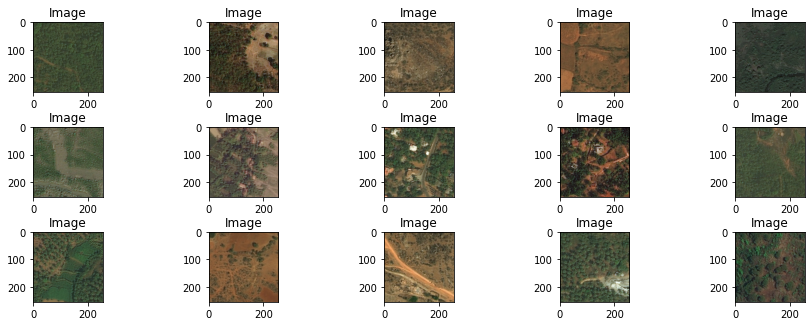

In [13]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title('Image')

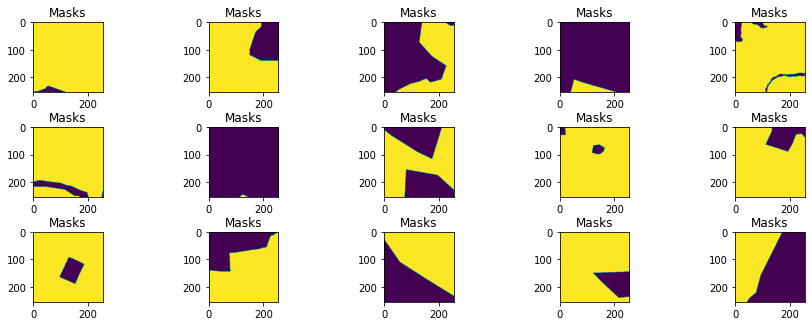

In [14]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Y[i])
    plt.title('Masks')

In [15]:
split = round(X.shape[0]*0.80)
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

In [16]:
datagen = ImageDataGenerator()
testgen = ImageDataGenerator()

In [17]:
datagen.fit(X_train)
testgen.fit(X_test)

### 3. Model definition

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 31s 3us/step


In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

NameError: name 'pix2pix' is not defined